# Public Transport Data Analysis

This notebook demonstrates how to:
- Connect to the PostGIS database
- Load and analyze passenger demand data
- Visualize stop clusters
- Create statistical visualizations


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sqlalchemy import create_engine
import sys
import os

# Add src to path to import modules
sys.path.insert(0, '/app/src')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Database connection
DB_CONNECTION_STRING = 'postgresql://user:password@db:5432/gtfs_db'
engine = create_engine(DB_CONNECTION_STRING)


## 1. Load Passenger Demand Data


In [2]:
# Load passenger demand
passengers_df = pd.read_csv('/app/data/raw/passenger_demand.csv')
print(f"Total passengers: {len(passengers_df):,}")
print(f"\nFirst few rows:")
passengers_df.head()


Total passengers: 1,560,000

First few rows:


,passenger_id,origin_id,destination_id,request_time
0,0,869,15187,19461
1,1,15888,871,65430
2,2,15716,3817,73872
3,3,15680,4725,37761
4,4,4127,1742,27639


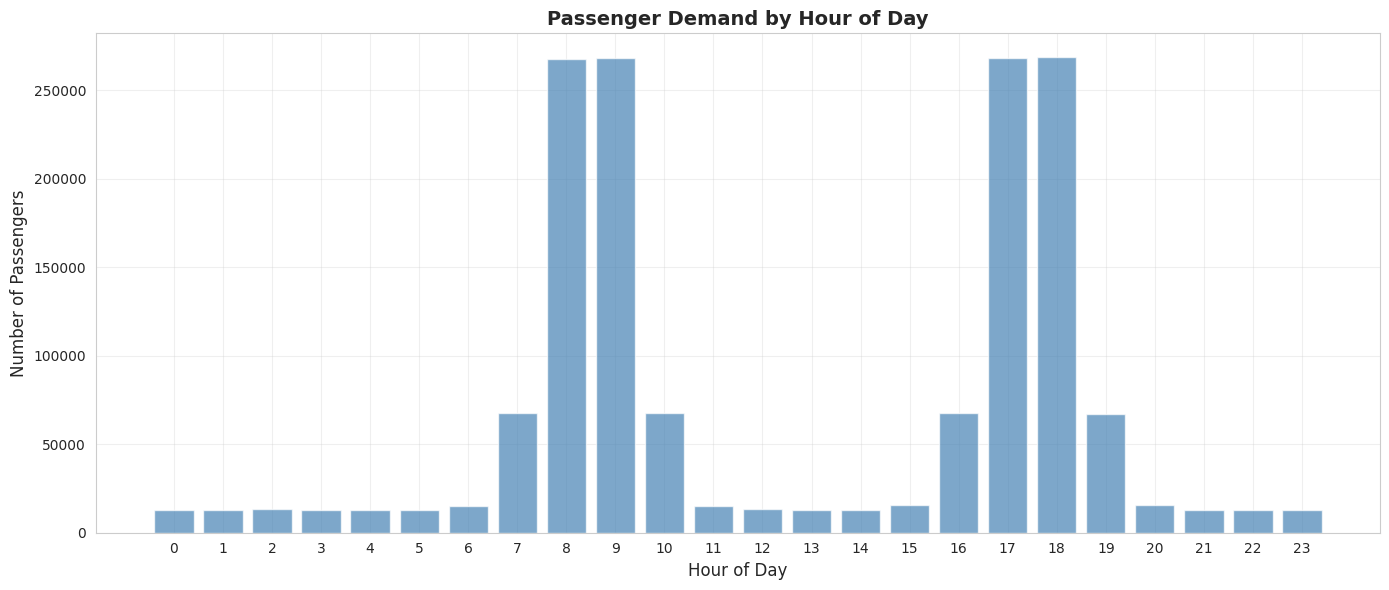

In [3]:
# Convert request_time to datetime-like format for analysis
passengers_df['hour'] = passengers_df['request_time'] // 3600
passengers_df['minute'] = (passengers_df['request_time'] % 3600) // 60

# Plot hourly distribution
fig, ax = plt.subplots(figsize=(14, 6))
hourly_counts = passengers_df['hour'].value_counts().sort_index()
ax.bar(hourly_counts.index, hourly_counts.values, color='steelblue', alpha=0.7)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Passengers', fontsize=12)
ax.set_title('Passenger Demand by Hour of Day', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


## 2. Load Stop Clusters


In [4]:
# Load cluster assignments
clusters_df = pd.read_csv('/app/data/raw/stop_clusters.csv')
print(f"Total stops: {len(clusters_df)}")
print(f"\nCluster distribution:")
clusters_df['cluster'].value_counts().sort_index()


Total stops: 6342

Cluster distribution:


cluster
0     327
1    1223
2      98
3     565
4     148
5      26
6     458
7     709
8     228
9    2560
Name: count, dtype: int64

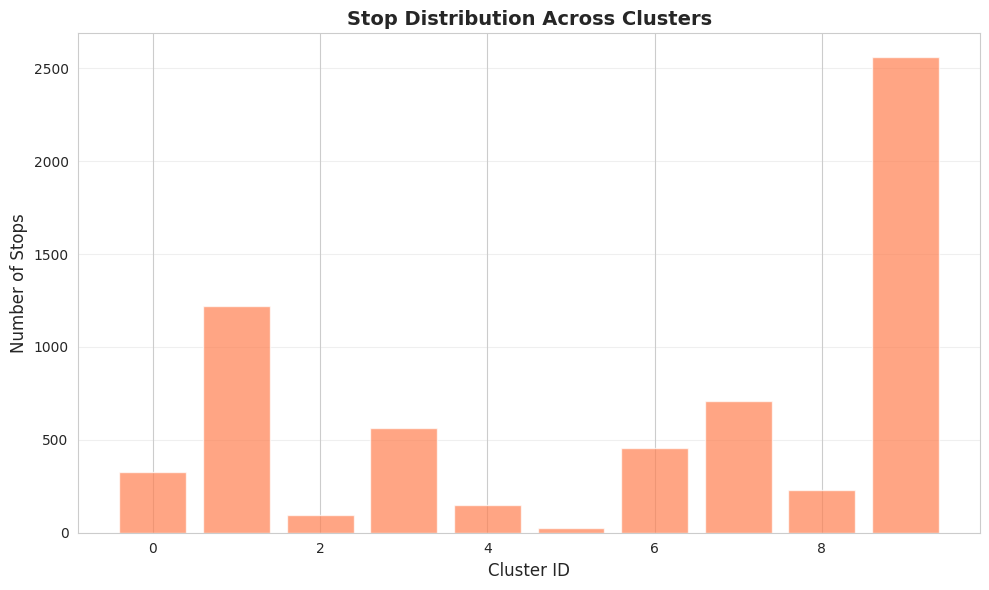

In [5]:
# Visualize cluster distribution
fig, ax = plt.subplots(figsize=(10, 6))
cluster_counts = clusters_df['cluster'].value_counts().sort_index()
ax.bar(cluster_counts.index, cluster_counts.values, color='coral', alpha=0.7)
ax.set_xlabel('Cluster ID', fontsize=12)
ax.set_ylabel('Number of Stops', fontsize=12)
ax.set_title('Stop Distribution Across Clusters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## 3. Geographic Visualization of Stops


/tmp/ipykernel_163/2677231222.py:20: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


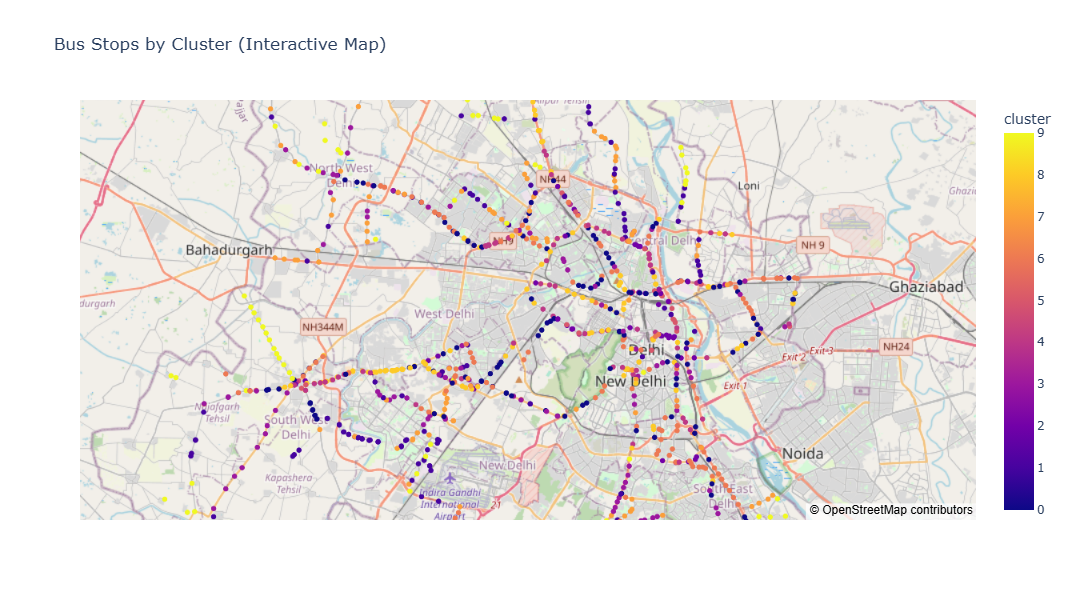

In [6]:
# Load stops with coordinates from database
# Use SELECT * to get all columns including geometry
stops_query = """
SELECT *
FROM stops_geospatial
LIMIT 1000
"""
stops_gdf = gpd.read_postgis(stops_query, engine, geom_col='geometry')

# Extract lat/lon from geometry if not already present
if 'stop_lat' not in stops_gdf.columns:
    stops_gdf['stop_lat'] = stops_gdf.geometry.y
if 'stop_lon' not in stops_gdf.columns:
    stops_gdf['stop_lon'] = stops_gdf.geometry.x

# Merge with clusters
stops_with_clusters = stops_gdf.merge(clusters_df, on='stop_id', how='left')

# Create interactive map with Plotly
fig = px.scatter_mapbox(
    stops_with_clusters,
    lat="stop_lat",
    lon="stop_lon",
    color="cluster",
    hover_data=["stop_name"],
    zoom=10,
    height=600,
    title="Bus Stops by Cluster (Interactive Map)"
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()


## 4. Passenger Demand by Cluster


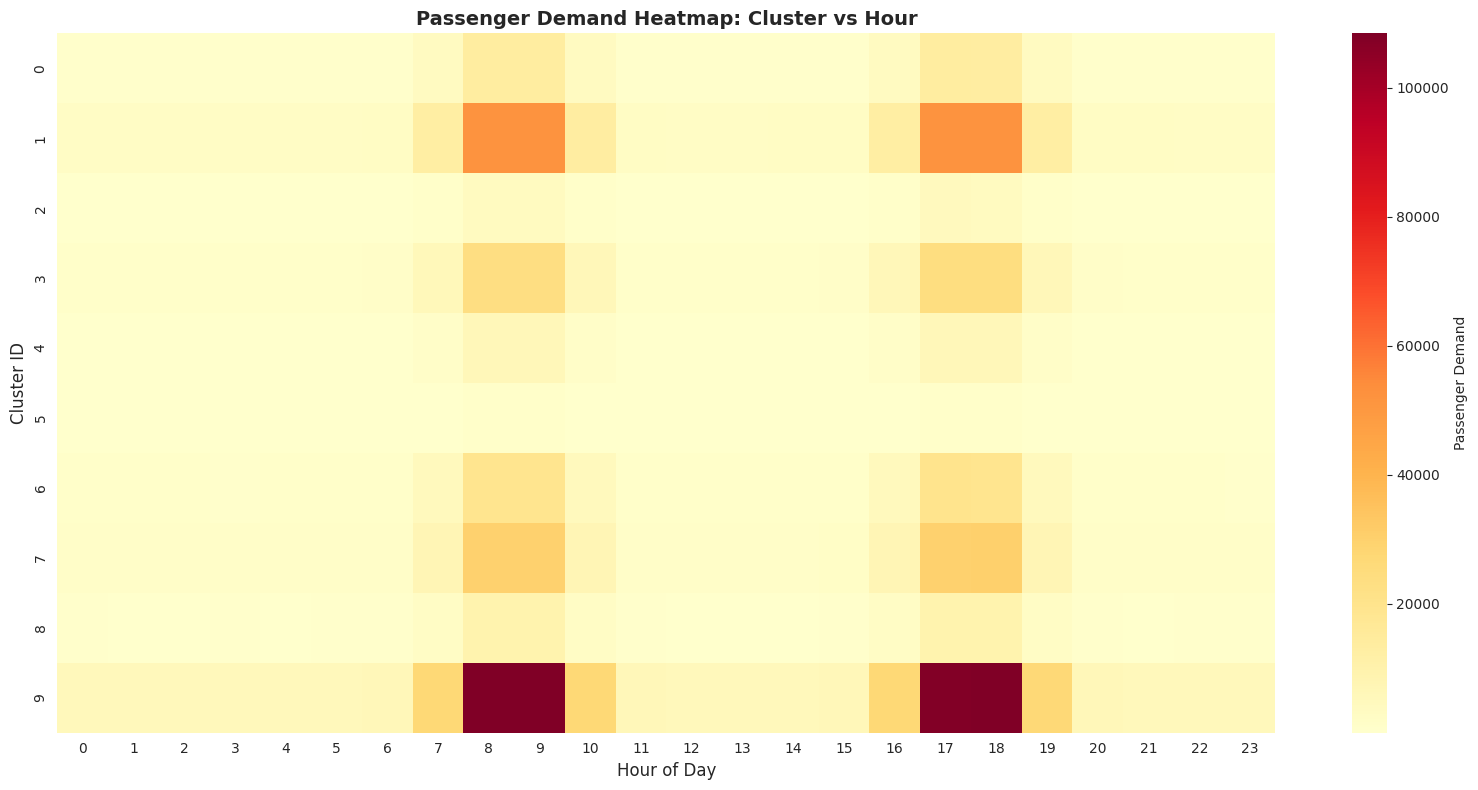

In [7]:
# Merge passengers with clusters
passengers_with_clusters = passengers_df.merge(
    clusters_df,
    left_on='origin_id',
    right_on='stop_id',
    how='left'
)

# Aggregate demand by cluster and hour
demand_by_cluster_hour = passengers_with_clusters.groupby(['cluster', 'hour']).size().reset_index(name='demand')

# Create heatmap
pivot_data = demand_by_cluster_hour.pivot(index='cluster', columns='hour', values='demand')

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(pivot_data, annot=False, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Passenger Demand'})
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Cluster ID', fontsize=12)
ax.set_title('Passenger Demand Heatmap: Cluster vs Hour', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Statistical Summary


In [8]:
# Summary statistics
print("=== Passenger Demand Statistics ===")
print(f"\nTotal Passengers: {len(passengers_df):,}")
print(f"Unique Origins: {passengers_df['origin_id'].nunique():,}")
print(f"Unique Destinations: {passengers_df['destination_id'].nunique():,}")
print(f"\nPeak Hour: {passengers_df['hour'].mode()[0]}:00")
print(f"Average Requests per Hour: {len(passengers_df) / 24:,.0f}")

# Demand by cluster
if 'cluster' in passengers_with_clusters.columns:
    print("\n=== Demand by Cluster ===")
    cluster_demand = passengers_with_clusters.groupby('cluster').size().sort_values(ascending=False)
    print(cluster_demand)


=== Passenger Demand Statistics ===

Total Passengers: 1,560,000
Unique Origins: 6,342
Unique Destinations: 6,342

Peak Hour: 18:00
Average Requests per Hour: 65,000

=== Demand by Cluster ===
cluster
9    629962
1    301781
7    174039
3    138187
6    112608
0     80145
8     56179
4     36491
2     24294
5      6314
dtype: int64


## 6. Load and Analyze Forecast Models


✓ Loaded Prophet model for cluster 0

=== Model Configuration ===
Daily seasonality: True
Weekly seasonality: True
Yearly seasonality: auto
Holidays included: True
  Number of holidays: 3

=== Model Parameters ===
Parameter groups: 7
Keys: ['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']

=== Sample Forecast ===
Forecast shape: (2184, 31)

Last 5 forecasted values (clipped to non-negative):
                      ds         yhat   yhat_lower    yhat_upper
2179 2024-10-30 19:00:00  7146.935323  3460.446006  10884.032079
2180 2024-10-30 20:00:00  2953.970598     0.000000   6778.645575
2181 2024-10-30 21:00:00     0.000000     0.000000   3550.966525
2182 2024-10-30 22:00:00     0.000000     0.000000   2624.434713
2183 2024-10-30 23:00:00     0.000000     0.000000   3426.618701


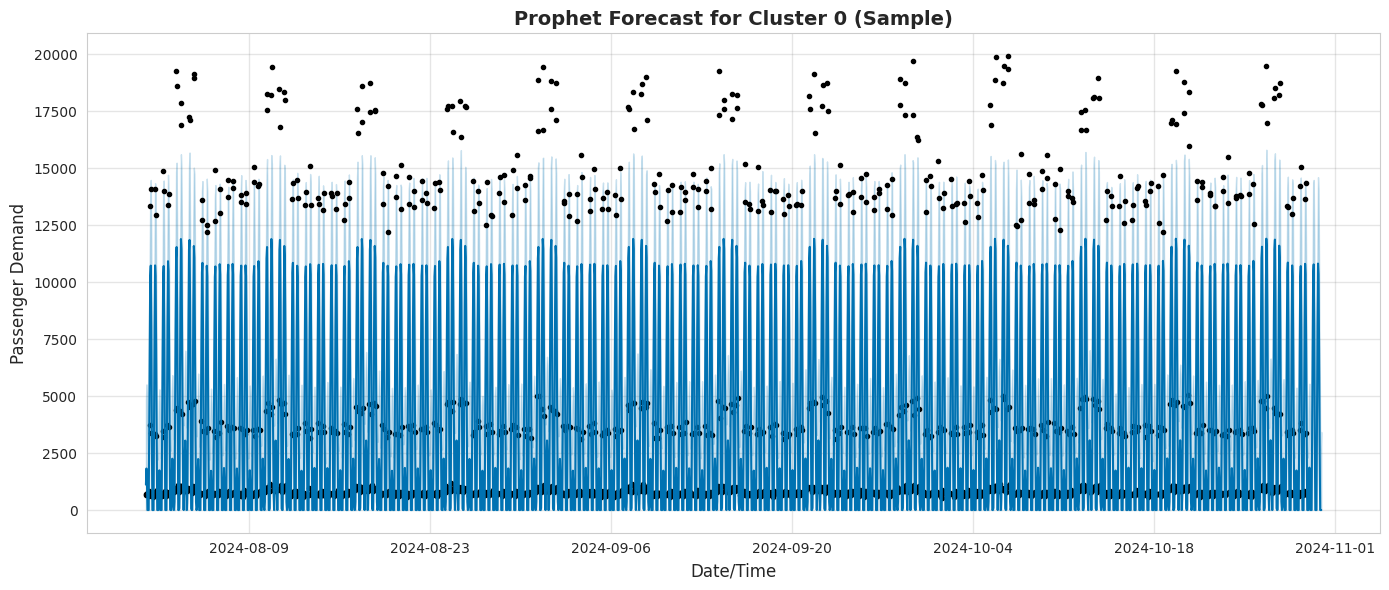

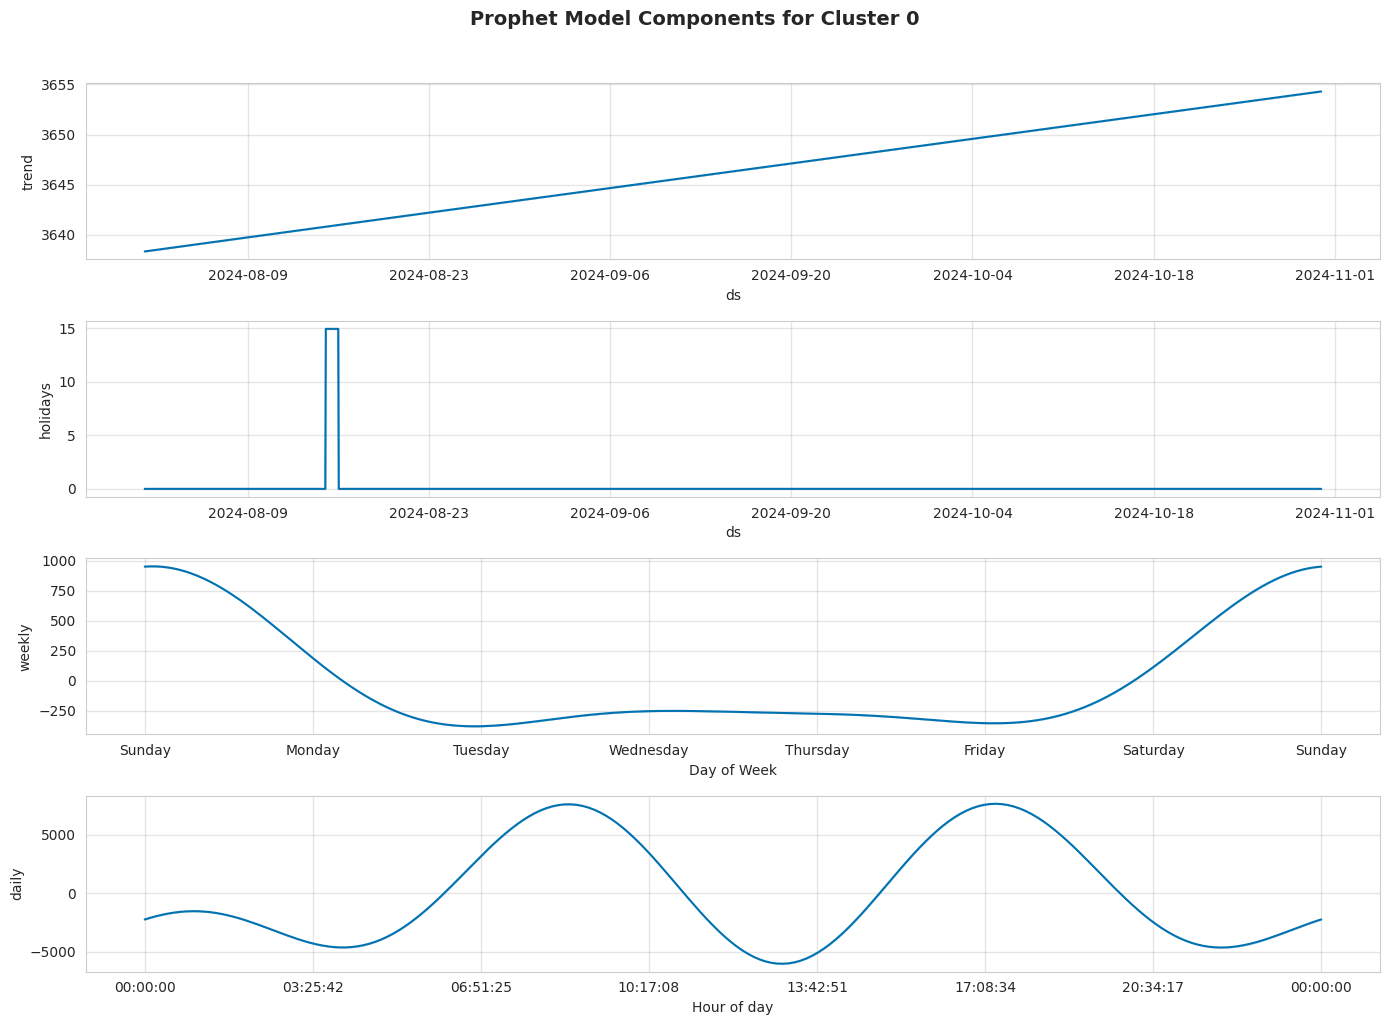

In [ ]:
import pickle
from pathlib import Path
import pandas as pd

# Load a Prophet model
models_dir = Path('/app/models_artifacts/forecast_models')
if (models_dir / 'prophet_model_cluster_0.pkl').exists():
    with open(models_dir / 'prophet_model_cluster_0.pkl', 'rb') as f:
        model = pickle.load(f)
    
    print("✓ Loaded Prophet model for cluster 0")
    print("\n=== Model Configuration ===")
    print(f"Daily seasonality: {model.daily_seasonality}")
    print(f"Weekly seasonality: {model.weekly_seasonality}")
    print(f"Yearly seasonality: {model.yearly_seasonality}")
    print(f"Holidays included: {model.holidays is not None}")
    if model.holidays is not None:
        print(f"  Number of holidays: {len(model.holidays)}")
    
    print("\n=== Model Parameters ===")
    # Prophet params is a dictionary with keys like 'k', 'm', 'sigma_obs', etc.
    param_keys = list(model.params.keys())
    print(f"Parameter groups: {len(param_keys)}")
    print(f"Keys: {param_keys}")
    
    # Make a sample forecast to demonstrate the model works
    print("\n=== Sample Forecast ===")
    future = model.make_future_dataframe(periods=24, freq='h')  # Next 24 hours (use 'h' not 'H')
    forecast = model.predict(future)
    
    # Clip negative values to 0 (passenger demand can't be negative)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    
    print(f"Forecast shape: {forecast.shape}")
    print("\nLast 5 forecasted values (clipped to non-negative):")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    
    # Plot the forecast
    fig = model.plot(forecast, figsize=(14, 6))
    plt.title('Prophet Forecast for Cluster 0 (Sample)', fontsize=14, fontweight='bold')
    plt.xlabel('Date/Time', fontsize=12)
    plt.ylabel('Passenger Demand', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Plot components
    fig = model.plot_components(forecast, figsize=(14, 10))
    plt.suptitle('Prophet Model Components for Cluster 0', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠ Forecast models not found. Run src/models/forecast.py first.")

## 7. Baseline vs Dynamic Scheduling Comparison

This section compares:
- **Baseline (Static)**: Traditional fixed schedule (same every day)
- **Dynamic (AI)**: AI-driven schedule based on Prophet forecasts

**Key Metrics to Compare:**
- Average Wait Time (minutes)
- Total Cost (₹)
- Total KMs Driven
- Passengers Failed


In [10]:
# Import simulation modules
import sys
sys.path.insert(0, '/app/src')

from simulation.baseline_sim import BaselineSimulation
from simulation.dynamic_sim import DynamicSimulation

print("✅ Simulation modules imported successfully!")
print("\n" + "="*60)
print("OPTIONS:")
print("="*60)
print("1. Run FULL simulations (1.56M passengers) - Use terminal:")
print("   docker compose run --rm web python src/simulation/baseline_sim.py")
print("   docker compose run --rm web python src/simulation/dynamic_sim.py")
print("\n2. Run SAMPLE in notebook (faster, for testing):")
print("   - Use sample_size parameter (e.g., 1000 passengers)")
print("   - See next cell for example")
print("="*60)


✅ Simulation modules imported successfully!

OPTIONS:
1. Run FULL simulations (1.56M passengers) - Use terminal:
   docker compose run --rm web python src/simulation/baseline_sim.py
   docker compose run --rm web python src/simulation/dynamic_sim.py

2. Run SAMPLE in notebook (faster, for testing):
   - Use sample_size parameter (e.g., 1000 passengers)
   - See next cell for example


In [11]:
# OPTION 1: Run with SAMPLE data in notebook (for quick testing)
USE_SAMPLE = False  # Set to True to run sample in notebook
SAMPLE_SIZE = 1000  # Number of passengers to simulate (for testing)

# OPTION 2: Auto-load from saved JSON files (RECOMMENDED)
# Results are automatically saved when you run simulations in terminal
BASELINE_RESULTS_FILE = Path('/app/data/processed/baseline_simulation_results.json')
DYNAMIC_RESULTS_FILE = Path('/app/data/processed/dynamic_simulation_results.json')

if USE_SAMPLE:
    print(f"🧪 Running SAMPLE simulations ({SAMPLE_SIZE:,} passengers)...")
    print("   This is for testing only. For full results, use terminal.\n")
    
    # Run baseline
    print("Running Baseline Simulation...")
    baseline_sim = BaselineSimulation(sample_size=SAMPLE_SIZE)
    baseline_results = baseline_sim.run()
    baseline_sim.print_results()
    
    print("\n" + "="*60 + "\n")
    
    # Run dynamic
    print("Running Dynamic Simulation...")
    dynamic_sim = DynamicSimulation(sample_size=SAMPLE_SIZE)
    dynamic_results = dynamic_sim.run()
    dynamic_sim.print_results()
    
    # Populate comparison dataframe
    comparison_data = {
        'Metric': [
            'Average Wait Time (minutes)',
            'Total Cost (₹)',
            'Total KMs Driven',
            'Passengers Served',
            'Passengers Failed',
            'Cost per Passenger (₹)'
        ],
        'Baseline (Static)': [
            baseline_results['average_wait_minutes'],
            baseline_results['total_cost'],
            baseline_results['total_km'],
            baseline_results['passengers_served'],
            baseline_results['passengers_failed'],
            baseline_results['cost_per_passenger']
        ],
        'Dynamic (AI)': [
            dynamic_results['average_wait_minutes'],
            dynamic_results['total_cost'],
            dynamic_results['total_km'],
            dynamic_results['passengers_served'],
            dynamic_results['passengers_failed'],
            dynamic_results['cost_per_passenger']
        ]
    }
    
elif BASELINE_RESULTS_FILE.exists() and DYNAMIC_RESULTS_FILE.exists():
    # OPTION 2: Auto-load from JSON files (RECOMMENDED)
    print("✅ Loading results from saved JSON files...\n")
    
    import json
    
    # Load baseline results
    with open(BASELINE_RESULTS_FILE, 'r', encoding='utf-8') as f:
        baseline_data = json.load(f)
    baseline_results = baseline_data['results']
    print(f"📊 Baseline results loaded (from {baseline_data['timestamp']})")
    print(f"   Sample size: {baseline_data['sample_size']:,} passengers\n")
    
    # Load dynamic results
    with open(DYNAMIC_RESULTS_FILE, 'r', encoding='utf-8') as f:
        dynamic_data = json.load(f)
    dynamic_results = dynamic_data['results']
    print(f"📊 Dynamic results loaded (from {dynamic_data['timestamp']})")
    print(f"   Sample size: {dynamic_data['sample_size']:,} passengers\n")
    
    # Populate comparison dataframe
    comparison_data = {
        'Metric': [
            'Average Wait Time (minutes)',
            'Total Cost (₹)',
            'Total KMs Driven',
            'Passengers Served',
            'Passengers Failed',
            'Cost per Passenger (₹)'
        ],
        'Baseline (Static)': [
            baseline_results['average_wait_minutes'],
            baseline_results['total_cost'],
            baseline_results['total_km'],
            baseline_results['passengers_served'],
            baseline_results['passengers_failed'],
            baseline_results['cost_per_passenger']
        ],
        'Dynamic (AI)': [
            dynamic_results['average_wait_minutes'],
            dynamic_results['total_cost'],
            dynamic_results['total_km'],
            dynamic_results['passengers_served'],
            dynamic_results['passengers_failed'],
            dynamic_results['cost_per_passenger']
        ]
    }
    print("✅ Results automatically loaded! No manual entry needed.\n")
    
else:
    # OPTION 3: Manual entry (fallback if files don't exist)
    print("⚠️  No saved results found. Please run simulations first:\n")
    print("   docker compose run --rm web python src/simulation/baseline_sim.py")
    print("   docker compose run --rm web python src/simulation/dynamic_sim.py\n")
    print("Results will be automatically saved to JSON files.\n")
    print("Then re-run this cell to auto-load the results.\n")
    
    comparison_data = {
        'Metric': [
            'Average Wait Time (minutes)',
            'Total Cost (₹)',
            'Total KMs Driven',
            'Passengers Served',
            'Passengers Failed',
            'Cost per Passenger (₹)'
        ],
        'Baseline (Static)': [None, None, None, None, None, None],
        'Dynamic (AI)': [None, None, None, None, None, None]
    }

comparison_df = pd.DataFrame(comparison_data)
print("Current comparison data:")
comparison_df


✅ Loading results from saved JSON files...

📊 Baseline results loaded (from 2025-11-14T17:55:40.354863)
   Sample size: 1,560,000 passengers

📊 Dynamic results loaded (from 2025-11-14T17:58:03.610019)
   Sample size: 1,560,000 passengers

✅ Results automatically loaded! No manual entry needed.

Current comparison data:


,Metric,Baseline (Static),Dynamic (AI)
0,Average Wait Time (minutes),5.682040e+00,5.220413e+01
1,Total Cost (₹),7.498770e+07,3.069084e+09
2,Total KMs Driven,6.450000e+05,2.639845e+07
3,Passengers Served,1.346080e+06,1.546116e+06
4,Passengers Failed,2.139200e+05,1.388400e+04
5,Cost per Passenger (₹),5.570820e+01,1.985028e+03


📈 Comparison Results:
                     Metric  Baseline (Static)  Dynamic (AI)  Improvement
Average Wait Time (minutes)       5.682040e+00  5.220413e+01      -818.76
             Total Cost (₹)       7.498770e+07  3.069084e+09     -3992.78
           Total KMs Driven       6.450000e+05  2.639845e+07     -3992.78
          Passengers Served       1.346080e+06  1.546116e+06       -14.86
          Passengers Failed       2.139200e+05  1.388400e+04        93.51
     Cost per Passenger (₹)       5.570820e+01  1.985028e+03     -3463.26


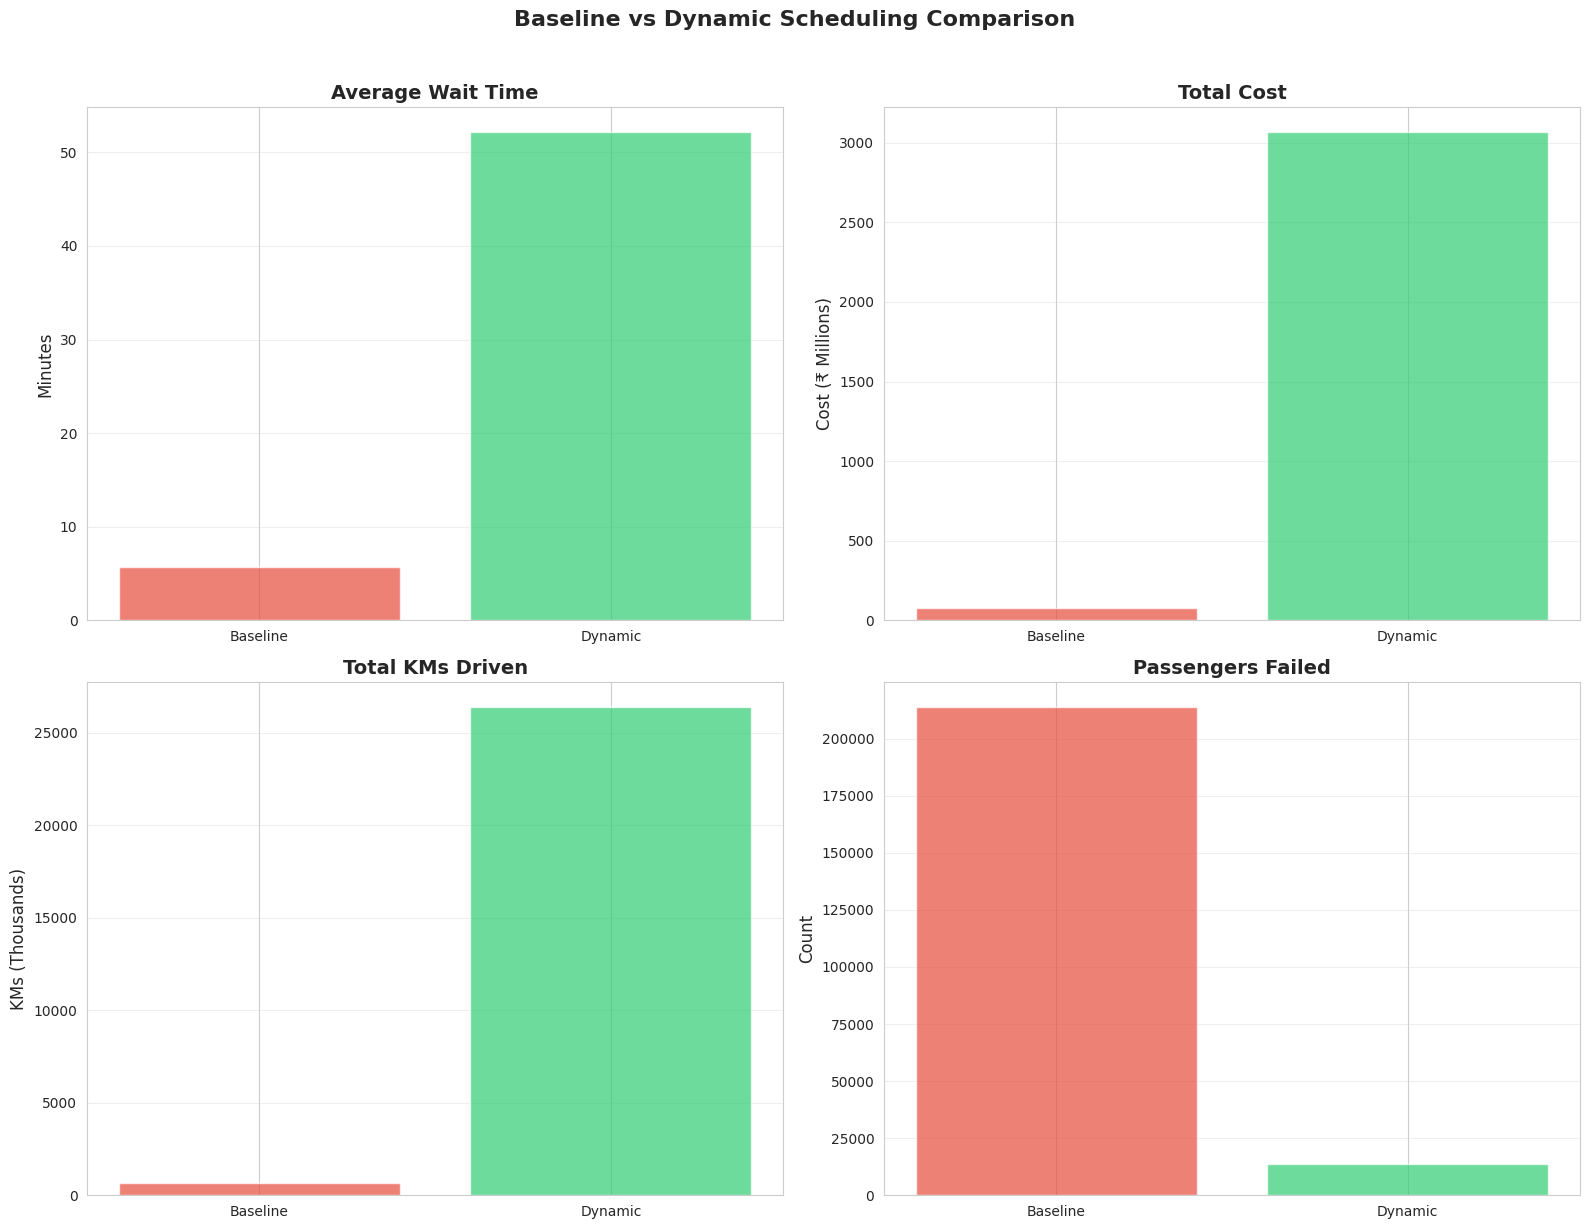


📊 Improvement Summary:
  ✗ Average Wait Time (minutes): 818.76% worse
  ✗ Total Cost (₹): 3992.78% worse
  ✗ Total KMs Driven: 3992.78% worse
  ✗ Passengers Served: 14.86% worse
  ✓ Passengers Failed: 93.51% improvement
  ✗ Cost per Passenger (₹): 3463.26% worse


In [12]:
# Visualize Comparison Results
# 
# NOTE: This cell processes the data that was automatically loaded in Cell 18.
# No manual entry needed! Just make sure Cell 18 ran successfully.
#
# Calculate improvements and create visualizations
if comparison_df['Baseline (Static)'].notna().any() and comparison_df['Dynamic (AI)'].notna().any():
    comparison_df['Improvement'] = (
        (comparison_df['Baseline (Static)'] - comparison_df['Dynamic (AI)']) 
        / comparison_df['Baseline (Static)'] * 100
    )
    comparison_df['Improvement'] = comparison_df['Improvement'].round(2)
    
    print("📈 Comparison Results:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Wait Time Comparison
    if pd.notna(comparison_df.loc[0, 'Baseline (Static)']):
        axes[0, 0].bar(['Baseline', 'Dynamic'], 
                      [comparison_df.loc[0, 'Baseline (Static)'], 
                       comparison_df.loc[0, 'Dynamic (AI)']],
                      color=['#e74c3c', '#2ecc71'], alpha=0.7)
        axes[0, 0].set_ylabel('Minutes', fontsize=12)
        axes[0, 0].set_title('Average Wait Time', fontsize=14, fontweight='bold')
        axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Cost Comparison
    if pd.notna(comparison_df.loc[1, 'Baseline (Static)']):
        axes[0, 1].bar(['Baseline', 'Dynamic'],
                      [comparison_df.loc[1, 'Baseline (Static)'] / 1e6,
                       comparison_df.loc[1, 'Dynamic (AI)'] / 1e6],
                      color=['#e74c3c', '#2ecc71'], alpha=0.7)
        axes[0, 1].set_ylabel('Cost (₹ Millions)', fontsize=12)
        axes[0, 1].set_title('Total Cost', fontsize=14, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. KMs Driven
    if pd.notna(comparison_df.loc[2, 'Baseline (Static)']):
        axes[1, 0].bar(['Baseline', 'Dynamic'],
                      [comparison_df.loc[2, 'Baseline (Static)'] / 1000,
                       comparison_df.loc[2, 'Dynamic (AI)'] / 1000],
                      color=['#e74c3c', '#2ecc71'], alpha=0.7)
        axes[1, 0].set_ylabel('KMs (Thousands)', fontsize=12)
        axes[1, 0].set_title('Total KMs Driven', fontsize=14, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Passengers Failed
    if pd.notna(comparison_df.loc[4, 'Baseline (Static)']):
        axes[1, 1].bar(['Baseline', 'Dynamic'],
                      [comparison_df.loc[4, 'Baseline (Static)'],
                       comparison_df.loc[4, 'Dynamic (AI)']],
                      color=['#e74c3c', '#2ecc71'], alpha=0.7)
        axes[1, 1].set_ylabel('Count', fontsize=12)
        axes[1, 1].set_title('Passengers Failed', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Baseline vs Dynamic Scheduling Comparison', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Improvement Summary
    if 'Improvement' in comparison_df.columns:
        print("\n📊 Improvement Summary:")
        improvements = comparison_df[['Metric', 'Improvement']].copy()
        improvements = improvements[improvements['Improvement'].notna()]
        for idx, row in improvements.iterrows():
            if row['Improvement'] > 0:
                print(f"  ✓ {row['Metric']}: {row['Improvement']:.2f}% improvement")
            elif row['Improvement'] < 0:
                print(f"  ✗ {row['Metric']}: {abs(row['Improvement']):.2f}% worse")
else:
    print("⚠️  No comparison data available.")
    print("   Please run Cell 18 first to load simulation results.")
    print("   If results don't exist, run simulations in terminal:")
    print("   docker compose run --rm web python src/simulation/baseline_sim.py")
    print("   docker compose run --rm web python src/simulation/dynamic_sim.py")


### Quick Run Instructions

**✅ AUTOMATED APPROACH (Recommended):**

1. **Run Baseline Simulation:**
   ```bash
   docker compose run --rm web python src/simulation/baseline_sim.py
   ```
   Results are automatically saved to `data/processed/baseline_simulation_results.json`

2. **Run Dynamic Simulation:**
   ```bash
   docker compose run --rm web python src/simulation/dynamic_sim.py
   ```
   Results are automatically saved to `data/processed/dynamic_simulation_results.json`

3. **Re-run cell 18** - Results will be automatically loaded from JSON files! No manual copying needed.

4. **Run cell 19** to see the comparison charts

**📊 What Gets Saved:**
- All simulation metrics (wait times, costs, KMs, passengers served/failed)
- Timestamp of when simulation was run
- Sample size used
- Results are saved in JSON format for easy loading

**Expected Improvements with Dynamic Scheduling:**
- ⬇️ Lower average wait times (AI dispatches buses proactively)
- ⬇️ Lower total cost (optimized bus deployment)
- ⬇️ Fewer failed passengers (better demand matching)
- ⬆️ Better resource utilization
